This notebook aims to implement the AlexNet model architecture from `One weird trick for parallelizing convolutional neural networks` <https://arxiv.org/abs/1404.5997> using NumPy. The objective is to be able to learn to replicate any existing model using other frameworks or programming languages and utilize the learned parameters trained by PyTorch.

# Import Packages

In [16]:
%pip install torch torchvision torchaudio numpy matplotlib scipy einops tqdm jupyter ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
from torchvision.models import alexnet, AlexNet_Weights
from torchvision.datasets import ImageNet

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from einops import einsum, rearrange, reduce

from tqdm.notebook import tqdm

from typing import Union, Tuple, Any, Generator
from torchvision.transforms._presets import ImageClassification

# Model and Parameters

# Transform
To replicate the AlexNet's performance, the input data must be identical. Hence, we will utilize the same transform as shown below.

In [18]:
weights = AlexNet_Weights.IMAGENET1K_V1
alexnet_transform = weights.transforms()
alexnet_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

## Labels
The int to string mapping of the labels of the ImageNet -- stored in a dictionary.

In [19]:
label_mapping = {}
for i, name in enumerate(weights.meta["categories"]):
    label_mapping[i] = name

label_mapping

{0: 'tench',
 1: 'goldfish',
 2: 'great white shark',
 3: 'tiger shark',
 4: 'hammerhead',
 5: 'electric ray',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich',
 10: 'brambling',
 11: 'goldfinch',
 12: 'house finch',
 13: 'junco',
 14: 'indigo bunting',
 15: 'robin',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel',
 21: 'kite',
 22: 'bald eagle',
 23: 'vulture',
 24: 'great grey owl',
 25: 'European fire salamander',
 26: 'common newt',
 27: 'eft',
 28: 'spotted salamander',
 29: 'axolotl',
 30: 'bullfrog',
 31: 'tree frog',
 32: 'tailed frog',
 33: 'loggerhead',
 34: 'leatherback turtle',
 35: 'mud turtle',
 36: 'terrapin',
 37: 'box turtle',
 38: 'banded gecko',
 39: 'common iguana',
 40: 'American chameleon',
 41: 'whiptail',
 42: 'agama',
 43: 'frilled lizard',
 44: 'alligator lizard',
 45: 'Gila monster',
 46: 'green lizard',
 47: 'African chameleon',
 48: 'Komodo dragon',
 49: 'African crocodile',
 50: 'American alligator',
 51: 'triceratops',
 

## Architecture
Below is the AlexNet architecture which we will strive to implement using NumPy. As showm, it consists of multiple blocks of `Conv2D-ReLU-MaxPool2d` and `Conv2D-ReLU`, then goes through a layer of `AdaptiveAvgPool2d`, and then finally goes through a series of fully-connected layers that utilizes dropout. Note that while there is Dropout, this is turned off during inference, hence can be disregarded as we already have the learned parameters injected into our model.

In [20]:
model = alexnet(weights=weights)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Below are the different tensor shapes of the parameters. Layer `i` is the weights tensor and Layer `i+1` is the bias tensor.

In [21]:
for layer_i, param in enumerate(model.parameters()):
    print('Layer', layer_i, 'shape: \n', param.shape,  '\n')

Layer 0 shape: 
 torch.Size([64, 3, 11, 11]) 

Layer 1 shape: 
 torch.Size([64]) 

Layer 2 shape: 
 torch.Size([192, 64, 5, 5]) 

Layer 3 shape: 
 torch.Size([192]) 

Layer 4 shape: 
 torch.Size([384, 192, 3, 3]) 

Layer 5 shape: 
 torch.Size([384]) 

Layer 6 shape: 
 torch.Size([256, 384, 3, 3]) 

Layer 7 shape: 
 torch.Size([256]) 

Layer 8 shape: 
 torch.Size([256, 256, 3, 3]) 

Layer 9 shape: 
 torch.Size([256]) 

Layer 10 shape: 
 torch.Size([4096, 9216]) 

Layer 11 shape: 
 torch.Size([4096]) 

Layer 12 shape: 
 torch.Size([4096, 4096]) 

Layer 13 shape: 
 torch.Size([4096]) 

Layer 14 shape: 
 torch.Size([1000, 4096]) 

Layer 15 shape: 
 torch.Size([1000]) 



# Images

In [22]:
BATCH_SIZE = 64

datapath = Path().cwd() / 'data'
imagenet = ImageNet(root=datapath,
                    split='val',
                    transform=alexnet_transform)
dataloader = torch.utils.data.DataLoader(imagenet,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)

In [23]:
print('Number of batches:', len(dataloader))

Number of batches: 782


In [24]:
def visualize_normalized_image(image: torch.Tensor, 
                               transform: ImageClassification) -> None:
    """
    Combines a batch of images into 1 and plots them.
    """
    assert isinstance(image, torch.Tensor), f'image type is {type(image)}'
    assert BATCH_SIZE % 2 == 0, f'uneven {BATCH_SIZE}'

    image = image.numpy()
    std, mean = transform.std, transform.mean
    std, mean = np.array(std), np.array(mean)

    b1, b2 = BATCH_SIZE//8, 8
    image = einsum(image, std, 'b c h w, c -> b h w c') + mean
    image = rearrange(image, '(b1 b2) h w c -> (b1 h) (b2 w) c', b1=b1, b2=b2)
    image = np.clip(image, 0, 1)
    
    plt.imshow(image)
    plt.axis('off')
    plt.show();
    
    print('Shape: ', image.shape)

Label 10 brambling


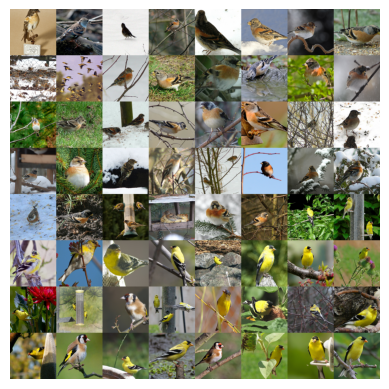

Shape:  (1792, 1792, 3)
Label 20 water ouzel


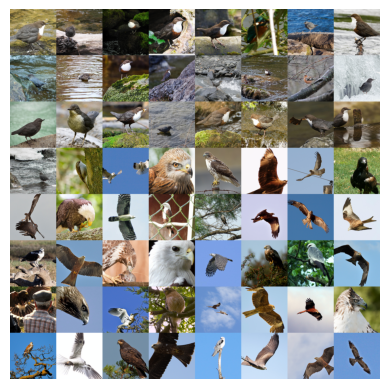

Shape:  (1792, 1792, 3)
Label 30 bullfrog


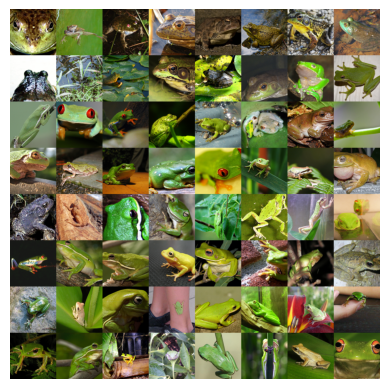

Shape:  (1792, 1792, 3)
Label 40 American chameleon


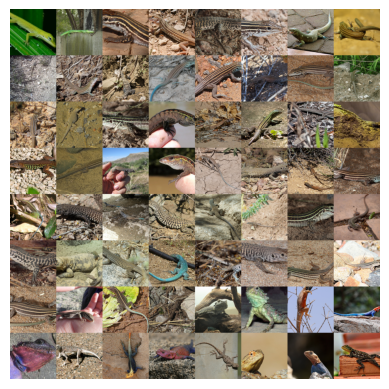

Shape:  (1792, 1792, 3)


In [25]:
n_of_batch_images_to_show = 4
current_label = 0

for i, (image, label) in enumerate(dataloader):
    label0 = int(label[0])

    if label0 - current_label >= 10:
        print('Label', label0, label_mapping[label0])
        visualize_normalized_image(image, alexnet_transform)
        n_of_batch_images_to_show -= 1
        current_label = label0

    if n_of_batch_images_to_show == 0:
        break


# Implementation of Different Layers

Each layer will be implemented using NumPy.

## Utility Functions & Class

In [26]:
def add_padding(x: np.ndarray, padding: Tuple) -> np.ndarray:
    """
    Adds padding on the 3rd and 4th dimension.
    """
    assert len(x.shape) == 4, 'x dim expects B C H W'
    return np.pad(
        x, 
        ((0, 0), 
         (0, 0), 
         (padding[0], padding[0]), 
         (padding[1], padding[1])), 
         mode='constant'
    )


def dim_out(dim: int, 
            kernel_size: int, 
            stride: int, 
            padding: int, 
            dilation: int, 
            ceil_mode: bool) -> int:
    """
    Calculates the output dimension given kernel_size, stride, padding, dilation
    and if ceiling or floor is preferred.
    """
    dim_out = dim + 2*padding - dilation * (kernel_size - 1) - 1
    dim_out /= stride
    dim_out += 1
    dim_out = np.ceil(dim_out) if ceil_mode else np.floor(dim_out)
    dim_out = int(dim_out)
    return dim_out


# def image_to_column(x, kernel_size, stride, padding, dilation, ceil_mode):
#     _, _, h, w = x.shape
#     p1, p2 = padding
#     k1, k2 = kernel_size
#     s1, s2 = stride
#     d1, d2 = dilation

#     h_out = dim_out(h, k1, s1, p1, d1, ceil_mode)
#     w_out = dim_out(w, k2, s2, p2, d2, ceil_mode)

#     x = add_padding(x, (p1, p2))
    
#     cols = []
#     for i in range(0, h_out*s1, s1):
#         for j in range(0, w_out*s2, s2):
#             patch = x[:, :, i:i+d1*k1:d1, j:j+d2*k2:d2]
#             flat_patch = rearrange(patch, 'b c h w -> b (c h w)')
#             cols.append(flat_patch)
#     cols = np.stack(cols, axis=-1)

#     return cols, h_out, w_out

def image_to_column(x: np.ndarray, 
                    kernel_size: Tuple, 
                    stride: Tuple, 
                    padding: Tuple, 
                    dilation: Tuple, 
                    ceil_mode: bool) -> Tuple[np.ndarray, int, int]:
    """
    Instead of directly pulling the patch affected by some kernel, all the
    possible patches are transformed into a vector and then stacked. This makes
    kernel operations or pooling much efficient and can be parallelized within
    the CPU space.
    """
    _, _, h, w = x.shape
    p1, p2 = padding
    k1, k2 = kernel_size
    s1, s2 = stride
    d1, d2 = dilation

    h_out = dim_out(h, k1, s1, p1, d1, ceil_mode)
    w_out = dim_out(w, k2, s2, p2, d2, ceil_mode)

    x = add_padding(x, (p1, p2))

    # extract sliding windows over H and W
    windows = np.lib.stride_tricks.sliding_window_view(x, 
                                                       (k1 * d1, k2 * d2), 
                                                       axis=(2, 3))
    # shape: (B, C, H_out_eff, W_out_eff, k1*d1, k2*d2)

    # downsample according to stride and dilation
    windows = windows[:, :, ::s1, ::s2, ::d1, ::d2]

    # flatten each patch into column
    cols = rearrange(windows, "b c ho wo kh kw -> b (c kh kw) (ho wo)")

    return cols, h_out, w_out


class Layer:
    """
    An object that takes tensor parameters (weights and biases.)
    """

    def __init__(self, 
                 weights: np.ndarray = None, 
                 bias: np.ndarray = None) -> None:
        self.weights = weights
        self.bias = bias

## Conv2D

In [27]:
class Conv2D(Layer):
    """
    A class that performs convolution on a given tensor.
    """
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: Union[int, Tuple] = 3,  
                 stride: Union[int, Tuple] = 1, 
                 padding: Union[int, Tuple] = 0,
                 dilation: Union[int, Tuple] = 1, 
                 ceil_mode: bool = False,
                 **kwargs: Any) -> None:
        super().__init__(**kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels

        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        self.kernel_size = kernel_size

        if isinstance(stride, int):
            stride = (stride, stride)        
        self.stride = stride

        if isinstance(padding, int):
            padding = (padding, padding)            
        self.padding = padding

        if isinstance(dilation, int):
            dilation = (dilation, dilation)  
        self.dilation = dilation

        self.ceil_mode = ceil_mode


    def forward(self, x: np.ndarray) -> np.ndarray:
        assert self.weights is not None, 'Missing Weights'
        assert self.bias is not None, 'Missing Bias'
        b, c, h, w = x.shape
        assert c == self.in_channels, f'in_channel: {self.in_channels} != {c}'

        kernels = self.weights
        y, h_out, w_out = image_to_column(x, 
                                          self.kernel_size, 
                                          self.stride, 
                                          self.padding, 
                                          self.dilation,
                                          self.ceil_mode)

        kernel_col = rearrange(kernels, 'f c h w -> f (c h w)')
        y = einsum(y, kernel_col, 'b h w, f h -> b f w')
        y += rearrange(self.bias, 'h -> 1 h 1')
        y = rearrange(y, 'b f (h w) -> b f h w', h=h_out, w=w_out)

        return y


    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.forward(x)

## ReLU

In [28]:
class ReLU:
    """
    A class that serves as the ReLU Activation function. Serves as a filter that
    only allows positive values to pass -- negative values become 0.
    """
    def forward(self, x: np.ndarray) -> np.ndarray:
        return np.maximum(x, 0)
    
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.forward(x)

## MaxPool2D

In [29]:
class MaxPool2D:
    """
    A class that performs max pooling on a given tensor.
    """

    def __init__(self, 
                 kernel_size: Union[Tuple, int] = 3, 
                 stride: Union[Tuple, int] = 1, 
                 padding: Union[Tuple, int] = 0, 
                 dilation: Union[Tuple, int] = 1, 
                 ceil_mode: bool = False) -> None:

        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        self.kernel_size = kernel_size

        if isinstance(stride, int):
            stride = (stride, stride)        
        self.stride = stride

        if isinstance(padding, int):
            padding = (padding, padding)            
        self.padding = padding

        if isinstance(dilation, int):
            dilation = (dilation, dilation)  
        self.dilation = dilation

        self.ceil_mode = ceil_mode

    
    def forward(self, x: np.ndarray) -> np.ndarray:
        b, f, h, w = x.shape
        
        y, h_out, w_out = image_to_column(x, 
                                          self.kernel_size, 
                                          self.stride, 
                                          self.padding, 
                                          self.dilation,
                                          self.ceil_mode)
        
        y = rearrange(y, 'b (i x) w -> b i x w', i=f)
        y = reduce(y, 'b i x w -> b i w', 'max')
        y = rearrange(y, 'b i (h w) -> b i h w', h=h_out, w=w_out)

        return y

    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.forward(x)

## AdaptiveAvgPool2D
https://discuss.pytorch.org/t/why-does-alexnet-in-torch-vision-use-average-pooling/84313

In [ ]:
class AdaptiveAvgPool2D:
    """
    Performs an average pooling but with the output size only dictated and other
    parameters such as stride or kernel size will adjust according to output
    size.
    """
    def __init__(self, output_size: int) -> None:
        if isinstance(output_size, int):
            output_size = (output_size, output_size)
        self.output_size = output_size

    def forward(self, x: np.ndarray) -> np.ndarray:
        b, c, h, w = x.shape
        h_out, w_out = self.output_size

        # if input_size is the same with out_putsize, then no need to perform
        # below
        if (h == h_out) and (w == w_out):
            return x
        
        y = np.zeros((b, c, h_out, w_out), dtype=x.dtype)

        for i in range(h_out):
            h_start = int(np.floor(i * h / h_out))
            h_end = int(np.ceil((i + 1) * h / h_out))
            for j in range(w_out):
                w_start = int(np.floor(j * w / w_out))
                w_end = int(np.ceil((j + 1) * w / w_out))
                
                region = x[:, :, h_start:h_end, w_start:w_end]
                y[:, :, i, j] = region.mean(axis=(2, 3))
        return y

    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.forward(x)

## Flatten

In [30]:
class Flatten:
    """
    A class that flattens a tensor based on provided axes.
    """

    def __init__(self, start_dim: int = 1, end_dim: int = -1) -> None:
        self.start_dim = start_dim
        self.end_dim = end_dim

    def forward(self, x: np.ndarray) -> np.ndarray:
        if self.end_dim == -1:
            self.end_dim = len(x.shape)
        first_third = x.shape[:self.start_dim]
        second_third = x.shape[self.start_dim:self.end_dim]
        last_third = x.shape[self.end_dim:]

        multiply_dim = int(np.prod(second_third))

        x = x.reshape((*first_third, multiply_dim, *last_third))
        
        return x
    
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.forward(x)


## Linear

In [31]:
class Linear(Layer):
    """
    A class that performs matrix multiplication of an input tensor and the
    provided parameters.
    """
    def __init__(self, in_features: int, 
                 out_features: int, 
                 **kwargs: Any) -> None:
        super().__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features

    def forward(self, x: np.ndarray) -> np.ndarray:
        y = einsum(x, self.weights, 'b i, o i -> b o') + self.bias
        return y

    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.forward(x)

## AlexNetNumpy

In [33]:
class AlexNetNumpy:
    """
    A NumPy implementation of AlexNet.
    """

    def __init__(self, 
                 pretrained_params: Generator[
                     torch.nn.parameter.Parameter, 
                     None, 
                     None
                ]) -> None:

        self.parameters = list(pretrained_params)
        weights1 = self.parameters[0].detach().numpy()
        bias1 = self.parameters[1].detach().numpy()
        weights2 = self.parameters[2].detach().numpy()
        bias2 = self.parameters[3].detach().numpy()
        weights3 = self.parameters[4].detach().numpy()
        bias3 = self.parameters[5].detach().numpy()
        weights4 = self.parameters[6].detach().numpy()
        bias4 = self.parameters[7].detach().numpy()
        weights5 = self.parameters[8].detach().numpy()
        bias5 = self.parameters[9].detach().numpy()
        weights6 = self.parameters[10].detach().numpy()
        bias6 = self.parameters[11].detach().numpy()
        weights7 = self.parameters[12].detach().numpy()
        bias7 = self.parameters[13].detach().numpy()
        weights8 = self.parameters[14].detach().numpy()
        bias8 = self.parameters[15].detach().numpy()

        self.conv1 = Conv2D(
            in_channels=3, 
            out_channels=64, 
            kernel_size=11, 
            stride=4, 
            padding=2, 
            weights=weights1, 
            bias=bias1
        )
        self.relu1 = ReLU()
        self.maxp1 = MaxPool2D(
            kernel_size=3, 
            stride=2, 
            padding=0, 
            dilation=1, 
            ceil_mode=False
        )

        self.conv2 = Conv2D(
            in_channels=64, 
            out_channels=192, 
            kernel_size=5, 
            stride=1, 
            padding=2, 
            weights=weights2, 
            bias=bias2
        )
        self.relu2 = ReLU()
        self.maxp2 = MaxPool2D(
            kernel_size=3, 
            stride=2, 
            padding=0, 
            dilation=1, 
            ceil_mode=False
        )

        self.conv3 = Conv2D(
            in_channels=192, 
            out_channels=384, 
            kernel_size=3, 
            stride=1, 
            padding=1, 
            weights=weights3, 
            bias=bias3
        )
        self.relu3 = ReLU()

        self.conv4 = Conv2D(
            in_channels=384, 
            out_channels=256, 
            kernel_size=3, 
            stride=1, 
            padding=1, 
            weights=weights4, 
            bias=bias4
        )
        self.relu4 = ReLU()

        self.conv5 = Conv2D(
            in_channels=256, 
            out_channels=256, 
            kernel_size=3, 
            stride=1,
            padding=1, 
            weights=weights5, 
            bias=bias5
        )
        self.relu5 = ReLU()
        self.maxp5 = MaxPool2D(
            kernel_size=3, 
            stride=2, 
            padding=0, 
            dilation=1, 
            ceil_mode=False
        )

        self.adapt = AdaptiveAvgPool2D(output_size=6)
        self.flatten = Flatten(start_dim=1, end_dim=-1)

        self.lin6 = Linear(
            in_features=9216,
            out_features=4096,
            weights=weights6,
            bias=bias6
            )
        self.relu6 = ReLU()

        self.lin7 = Linear(
            in_features=4096,
            out_features=4096,
            weights=weights7,
            bias=bias7
        )
        self.relu7 = ReLU()

        self.lin8 = Linear(
            in_features=4096,
            out_features=1000,
            weights=weights8,
            bias=bias8
        )

    def forward(self, x: np.ndarray) -> np.ndarray:
        y = self.maxp1(self.relu1(self.conv1(x)))
        self._block1 = y

        y = self.maxp2(self.relu2(self.conv2(y)))
        self._block2 = y

        y = self.relu3(self.conv3(y))
        self._block3 = y

        y = self.relu4(self.conv4(y))
        self._block4 = y

        y = self.maxp5(self.relu5(self.conv5(y)))
        self._block5 = y

        y = self.flatten(self.adapt(y))
        y = self.relu6(self.lin6(y))
        y = self.relu7(self.lin7(y))
        y = self.lin8(y)

        return y.argmax(axis=1)
    
    def predict(self, x: np.ndarray) -> np.ndarray:
        return self.forward(x)

## Evaluation of Validation Data

In [34]:
alexnetnp = AlexNetNumpy(model.parameters())

In [ ]:
total_correct = 0
total_called = 0
accuracy_per_10 = []

i = 0
for image, label in tqdm(dataloader):
    image, label = image.numpy(), label.numpy()
    pred = alexnetnp.predict(image)
    total_called += len(pred)

    total_correct += (pred == label).sum()
    i += 1
    if i % 10 == 0:
        accuracy_per_10.append((accuracy:=total_correct/total_called))
        print(f'Batch: {i} \nRunning Accuracy: {accuracy}\n')

  0%|          | 0/782 [00:00<?, ?it/s]

Batch: 10 
Running Accuracy: 0.7234375

Batch: 20 
Running Accuracy: 0.75234375

Batch: 30 
Running Accuracy: 0.6953125

Batch: 40 
Running Accuracy: 0.655859375

Batch: 50 
Running Accuracy: 0.62125

Batch: 60 
Running Accuracy: 0.6122395833333333

Batch: 70 
Running Accuracy: 0.6303571428571428

Batch: 80 
Running Accuracy: 0.651953125

Batch: 90 
Running Accuracy: 0.6508680555555556

Batch: 100 
Running Accuracy: 0.64296875

Batch: 110 
Running Accuracy: 0.6555397727272727

Batch: 120 
Running Accuracy: 0.662890625

Batch: 130 
Running Accuracy: 0.6567307692307692

Batch: 140 
Running Accuracy: 0.6482142857142857

Batch: 150 
Running Accuracy: 0.6426041666666666

Batch: 160 
Running Accuracy: 0.63876953125

Batch: 170 
Running Accuracy: 0.6364889705882353

Batch: 180 
Running Accuracy: 0.6346354166666667

Batch: 190 
Running Accuracy: 0.6311677631578947

Batch: 200 
Running Accuracy: 0.63125

Batch: 210 
Running Accuracy: 0.6311011904761905

Batch: 220 
Running Accuracy: 0.632102272

In [27]:
print('Total correct predictions: ', total_correct)
print('Total Predictions: ', total_called)
print(f'Accuracy: {(accuracy:=total_correct/total_called)}')

Total correct predictions:  28278
Total Predictions:  50000
Accuracy: 0.56556


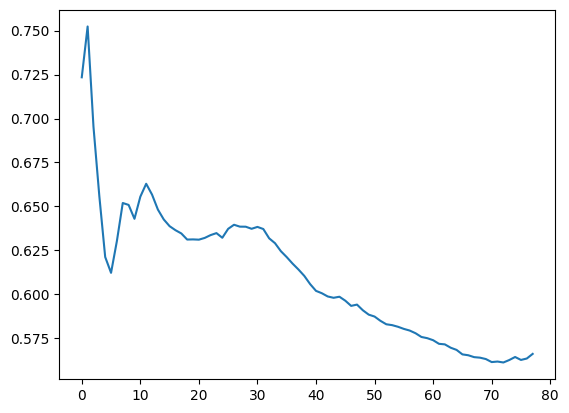

In [23]:
plt.plot(accuracy_per_10)

# Visualizations of Convolutions

## Image from DataLoader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].


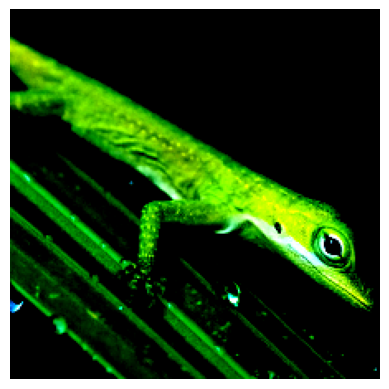

In [35]:
test_batch_image = image.numpy()

plt.imshow(rearrange(test_batch_image, 'b c h w -> b h w c')[0])
plt.axis('off')
plt.show()

## Conv2D Transformation

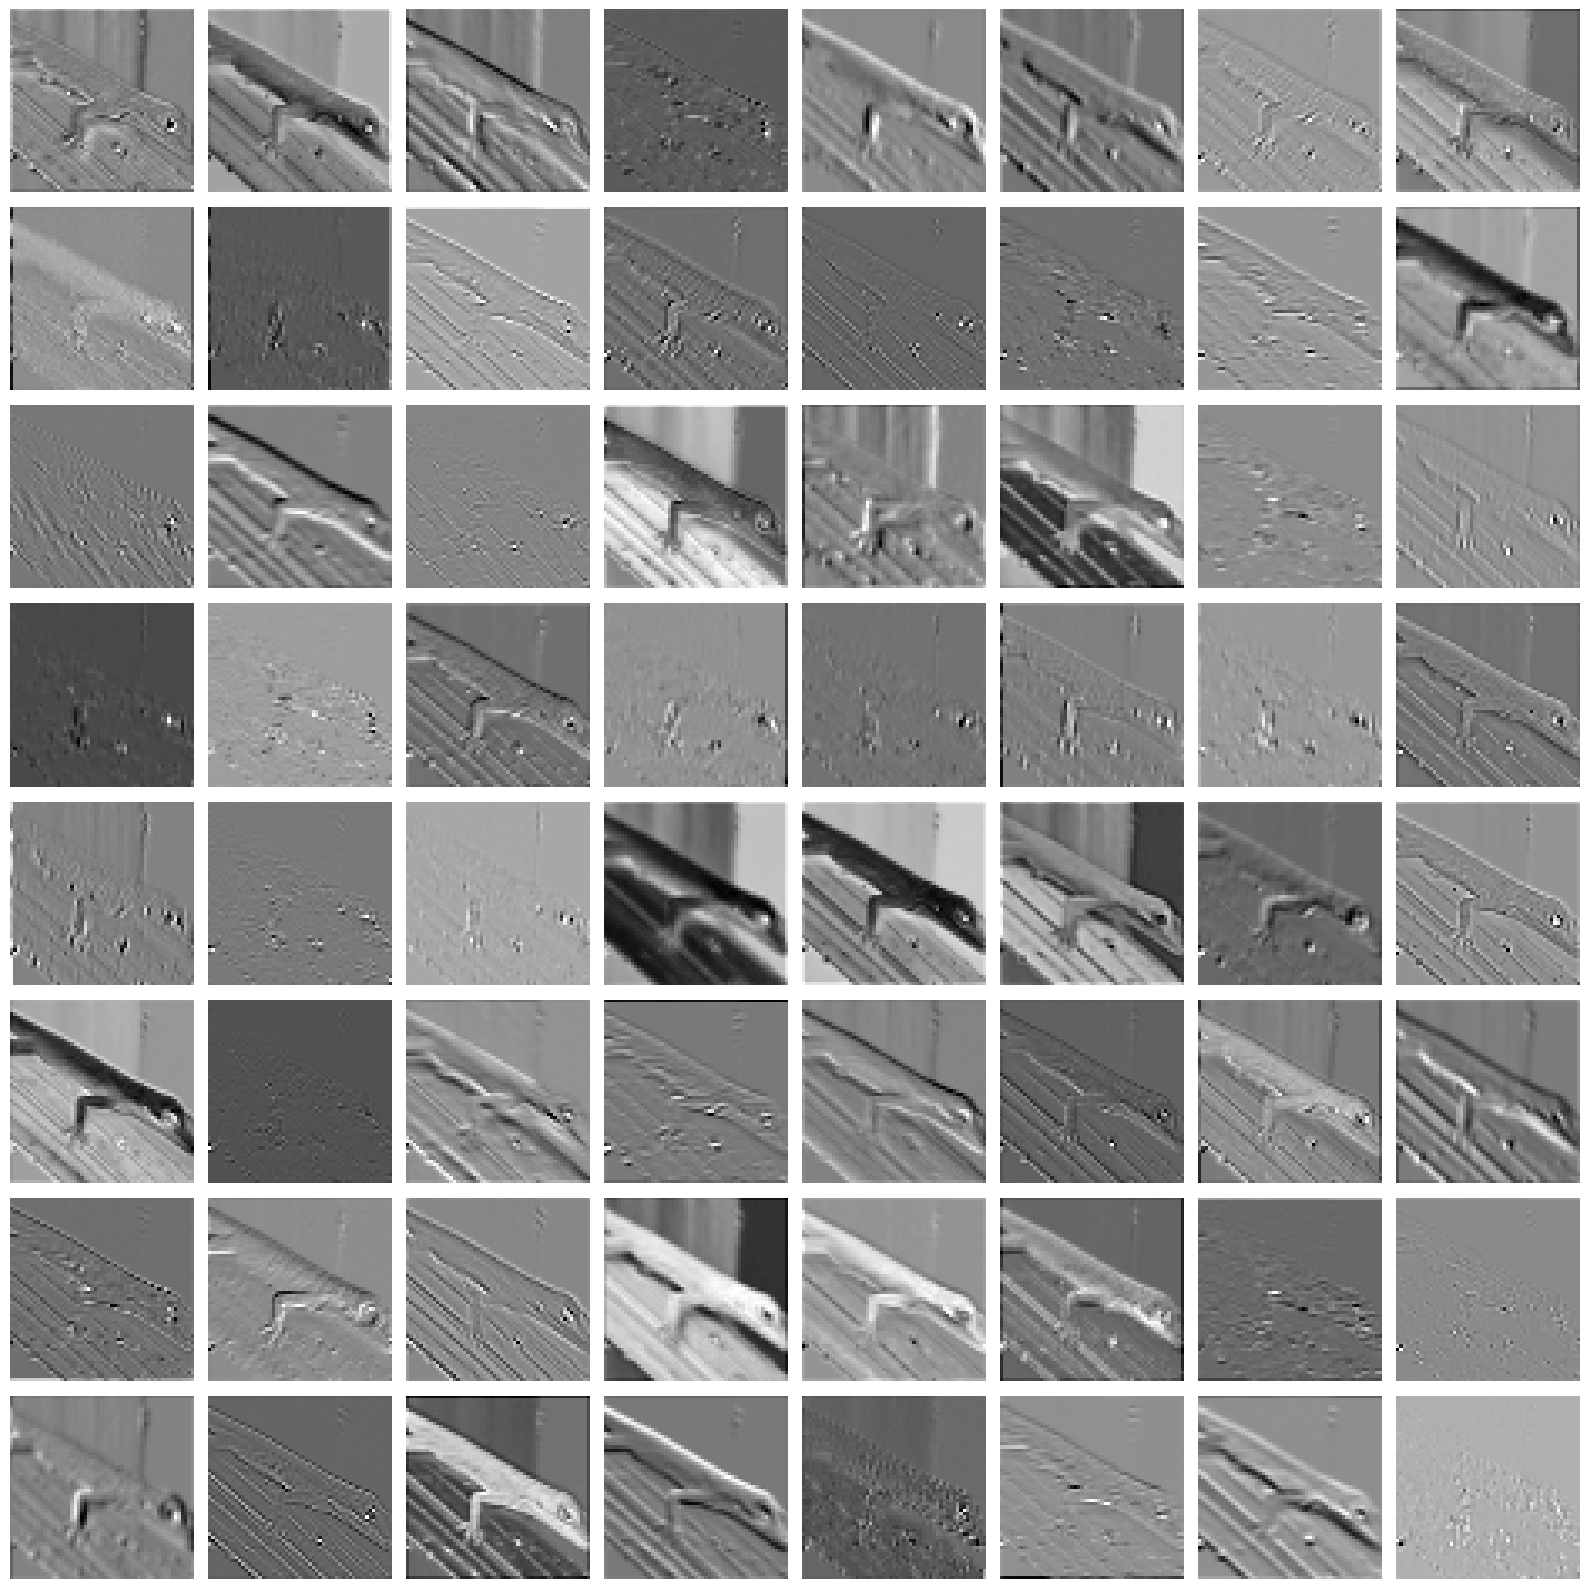

In [36]:
conv1_image = alexnetnp.conv1(test_batch_image[:1])[0]

fig, axes = plt.subplots(8, 8, figsize=(16, 16))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(conv1_image[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

## ReLU Transformation

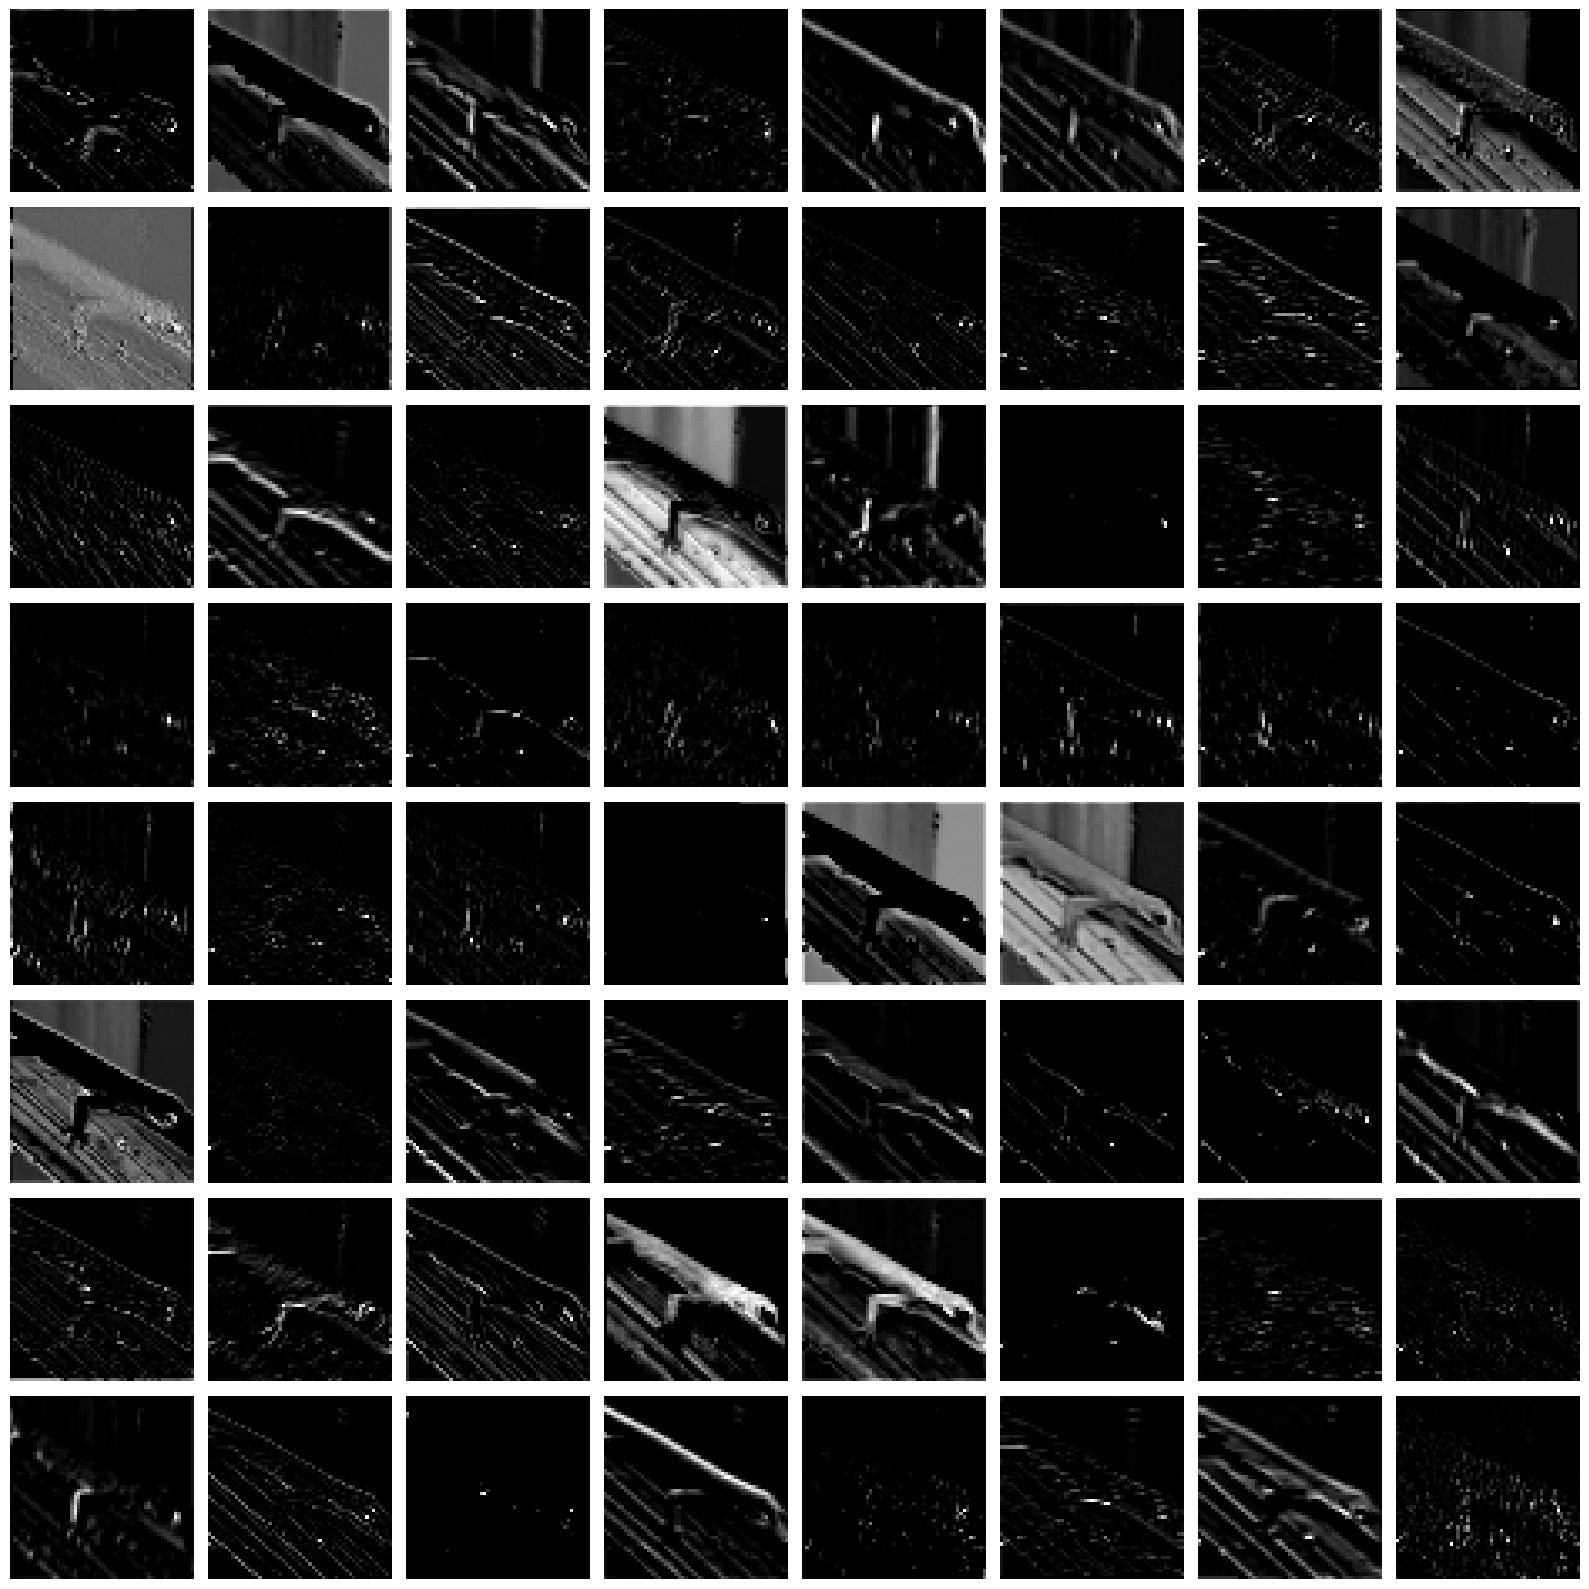

In [41]:
relu_conv1_image = alexnetnp.relu1(alexnetnp.conv1(test_batch_image[:1]))[0]

fig, axes = plt.subplots(8, 8, figsize=(16, 16))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(relu_conv1_image[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

## MaxPool2D Transformation

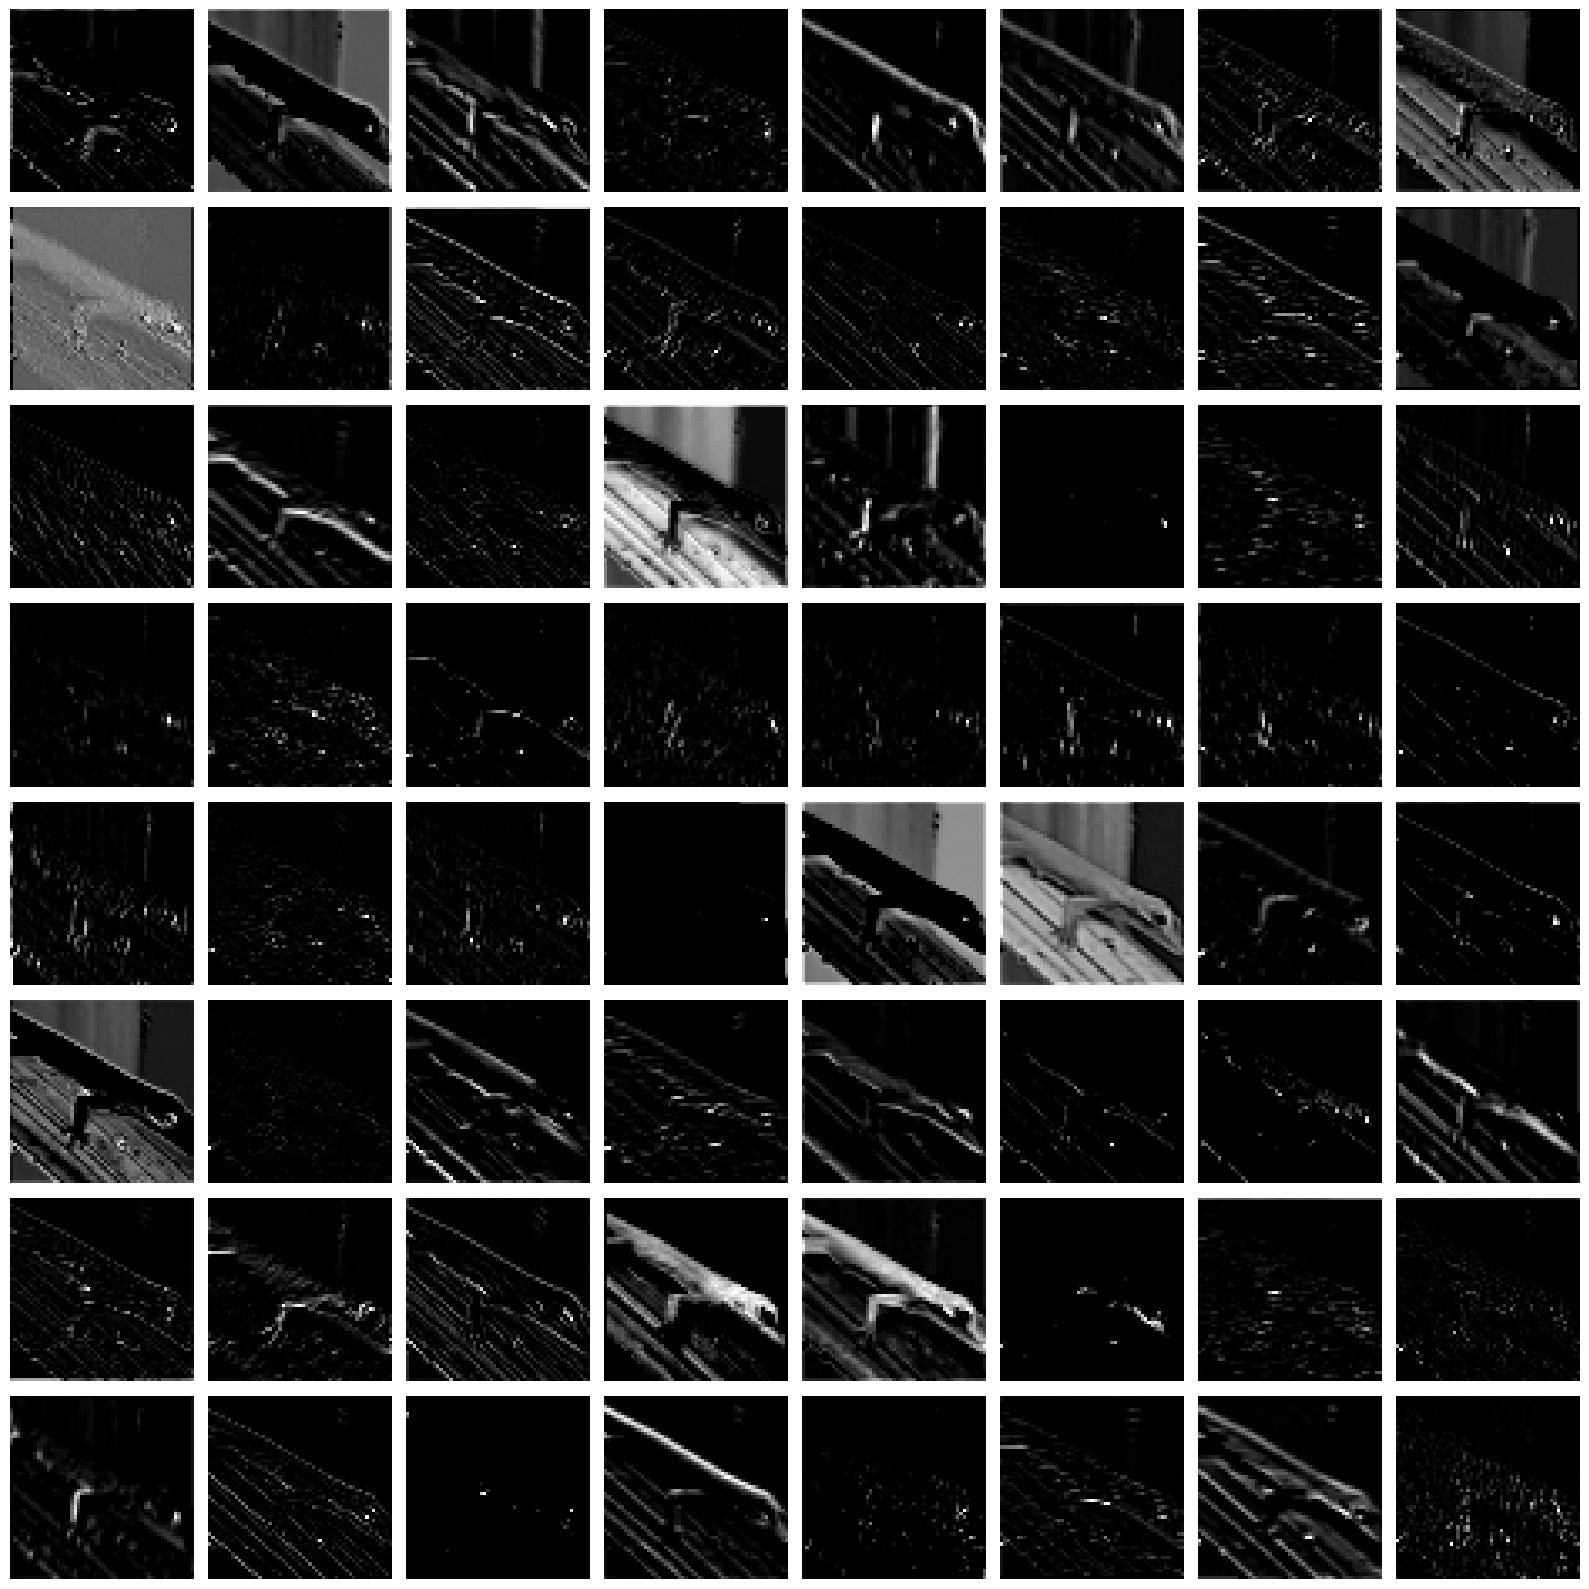

In [ ]:
maxp_relu_conv1_image = alexnetnp.maxp1(
    alexnetnp.relu1(
        alexnetnp.conv1(
            test_batch_image[:1]
        )
    )
)[0]

fig, axes = plt.subplots(8, 8, figsize=(16, 16))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(relu_conv1_image[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Block Visualizations

In [ ]:
_ = alexnetnp.predict(test_batch_image)

### Block 1

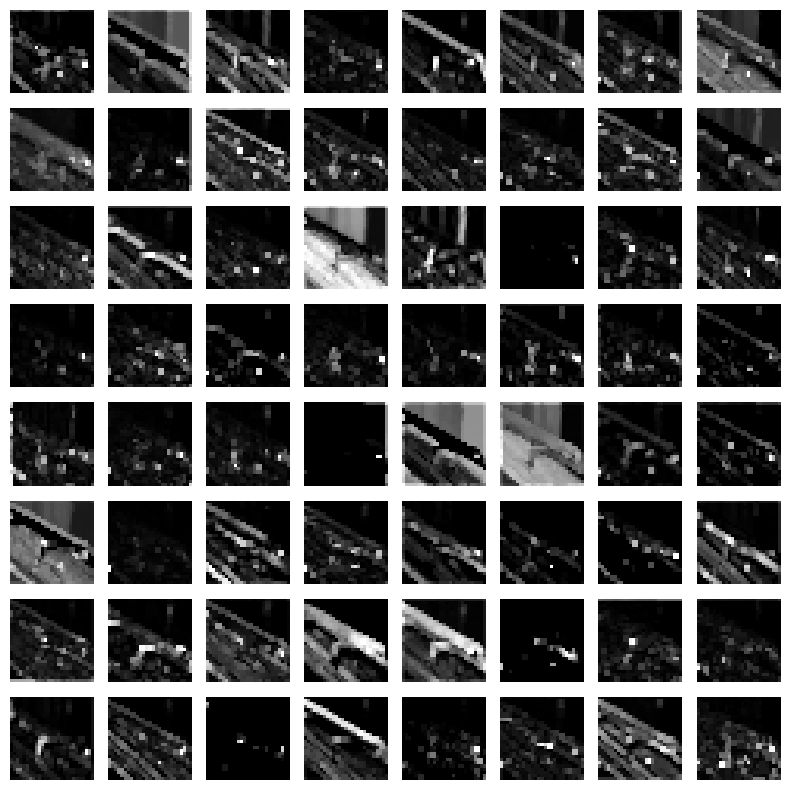

In [90]:
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(alexnetnp._block1[0][i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Block 2

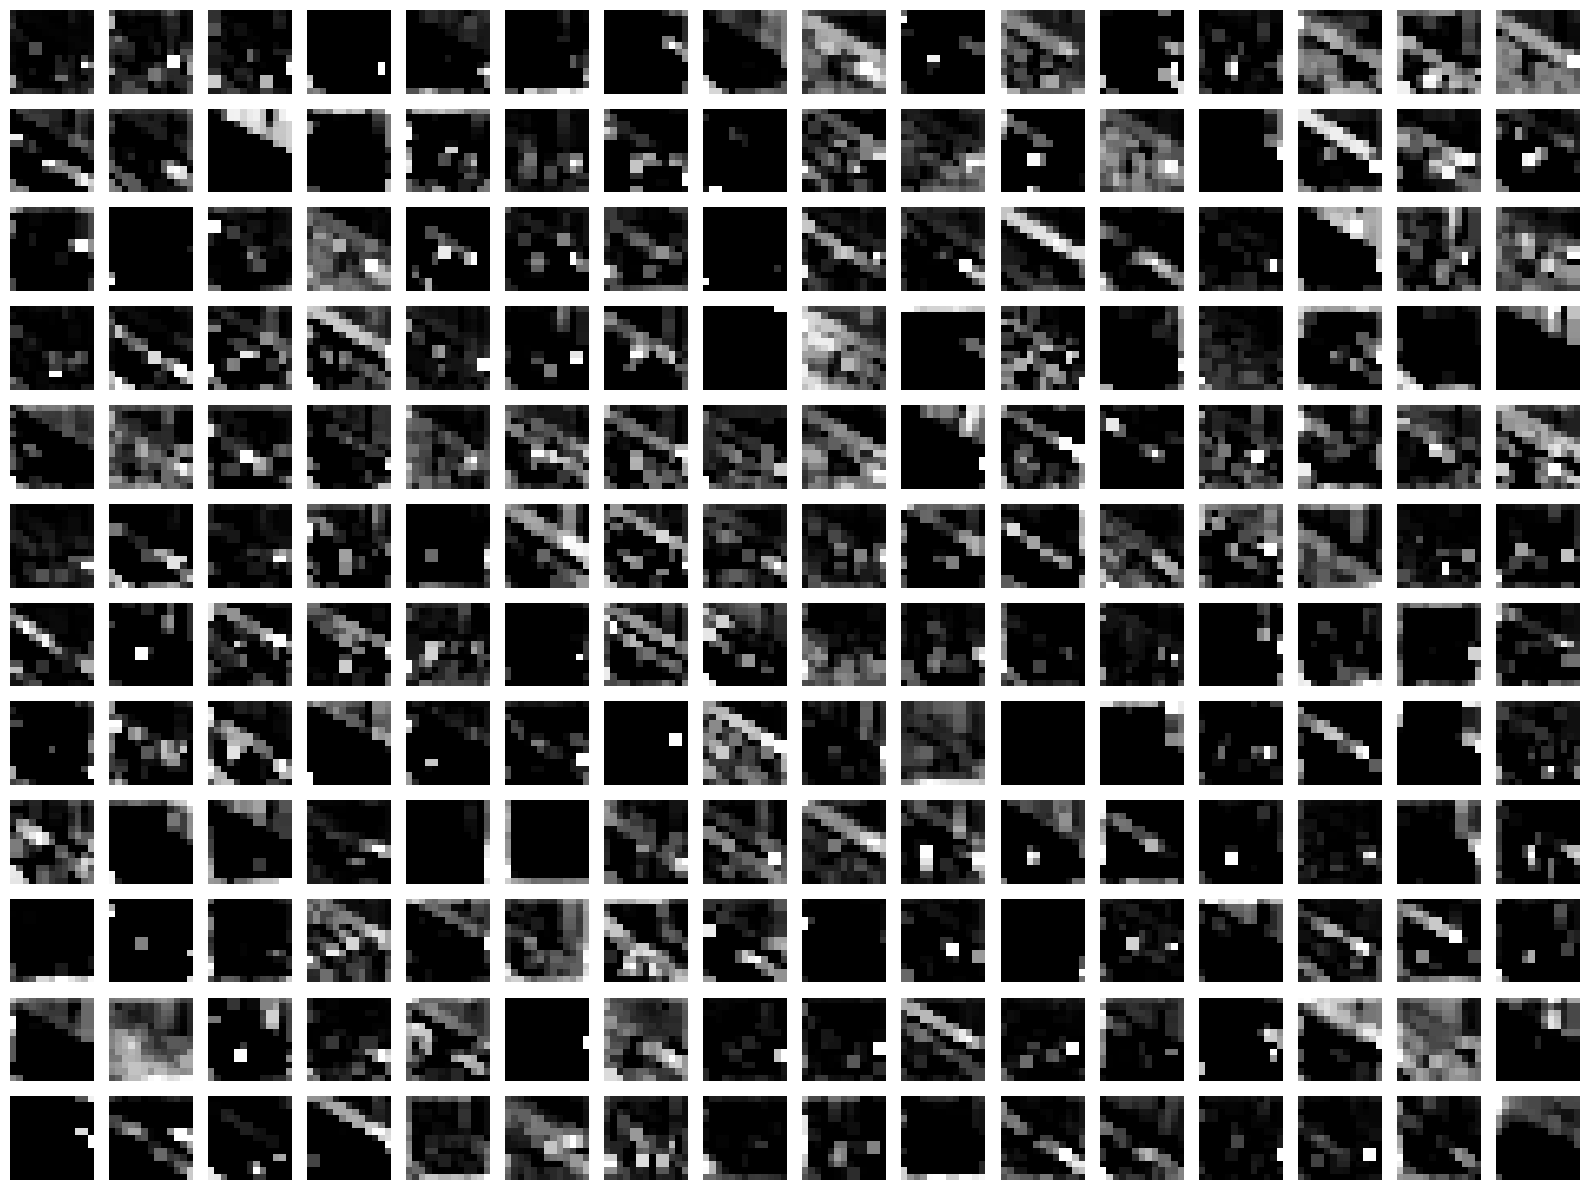

In [96]:
fig, axes = plt.subplots(12, 16, figsize=(16, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(alexnetnp._block2[0][i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Block 3

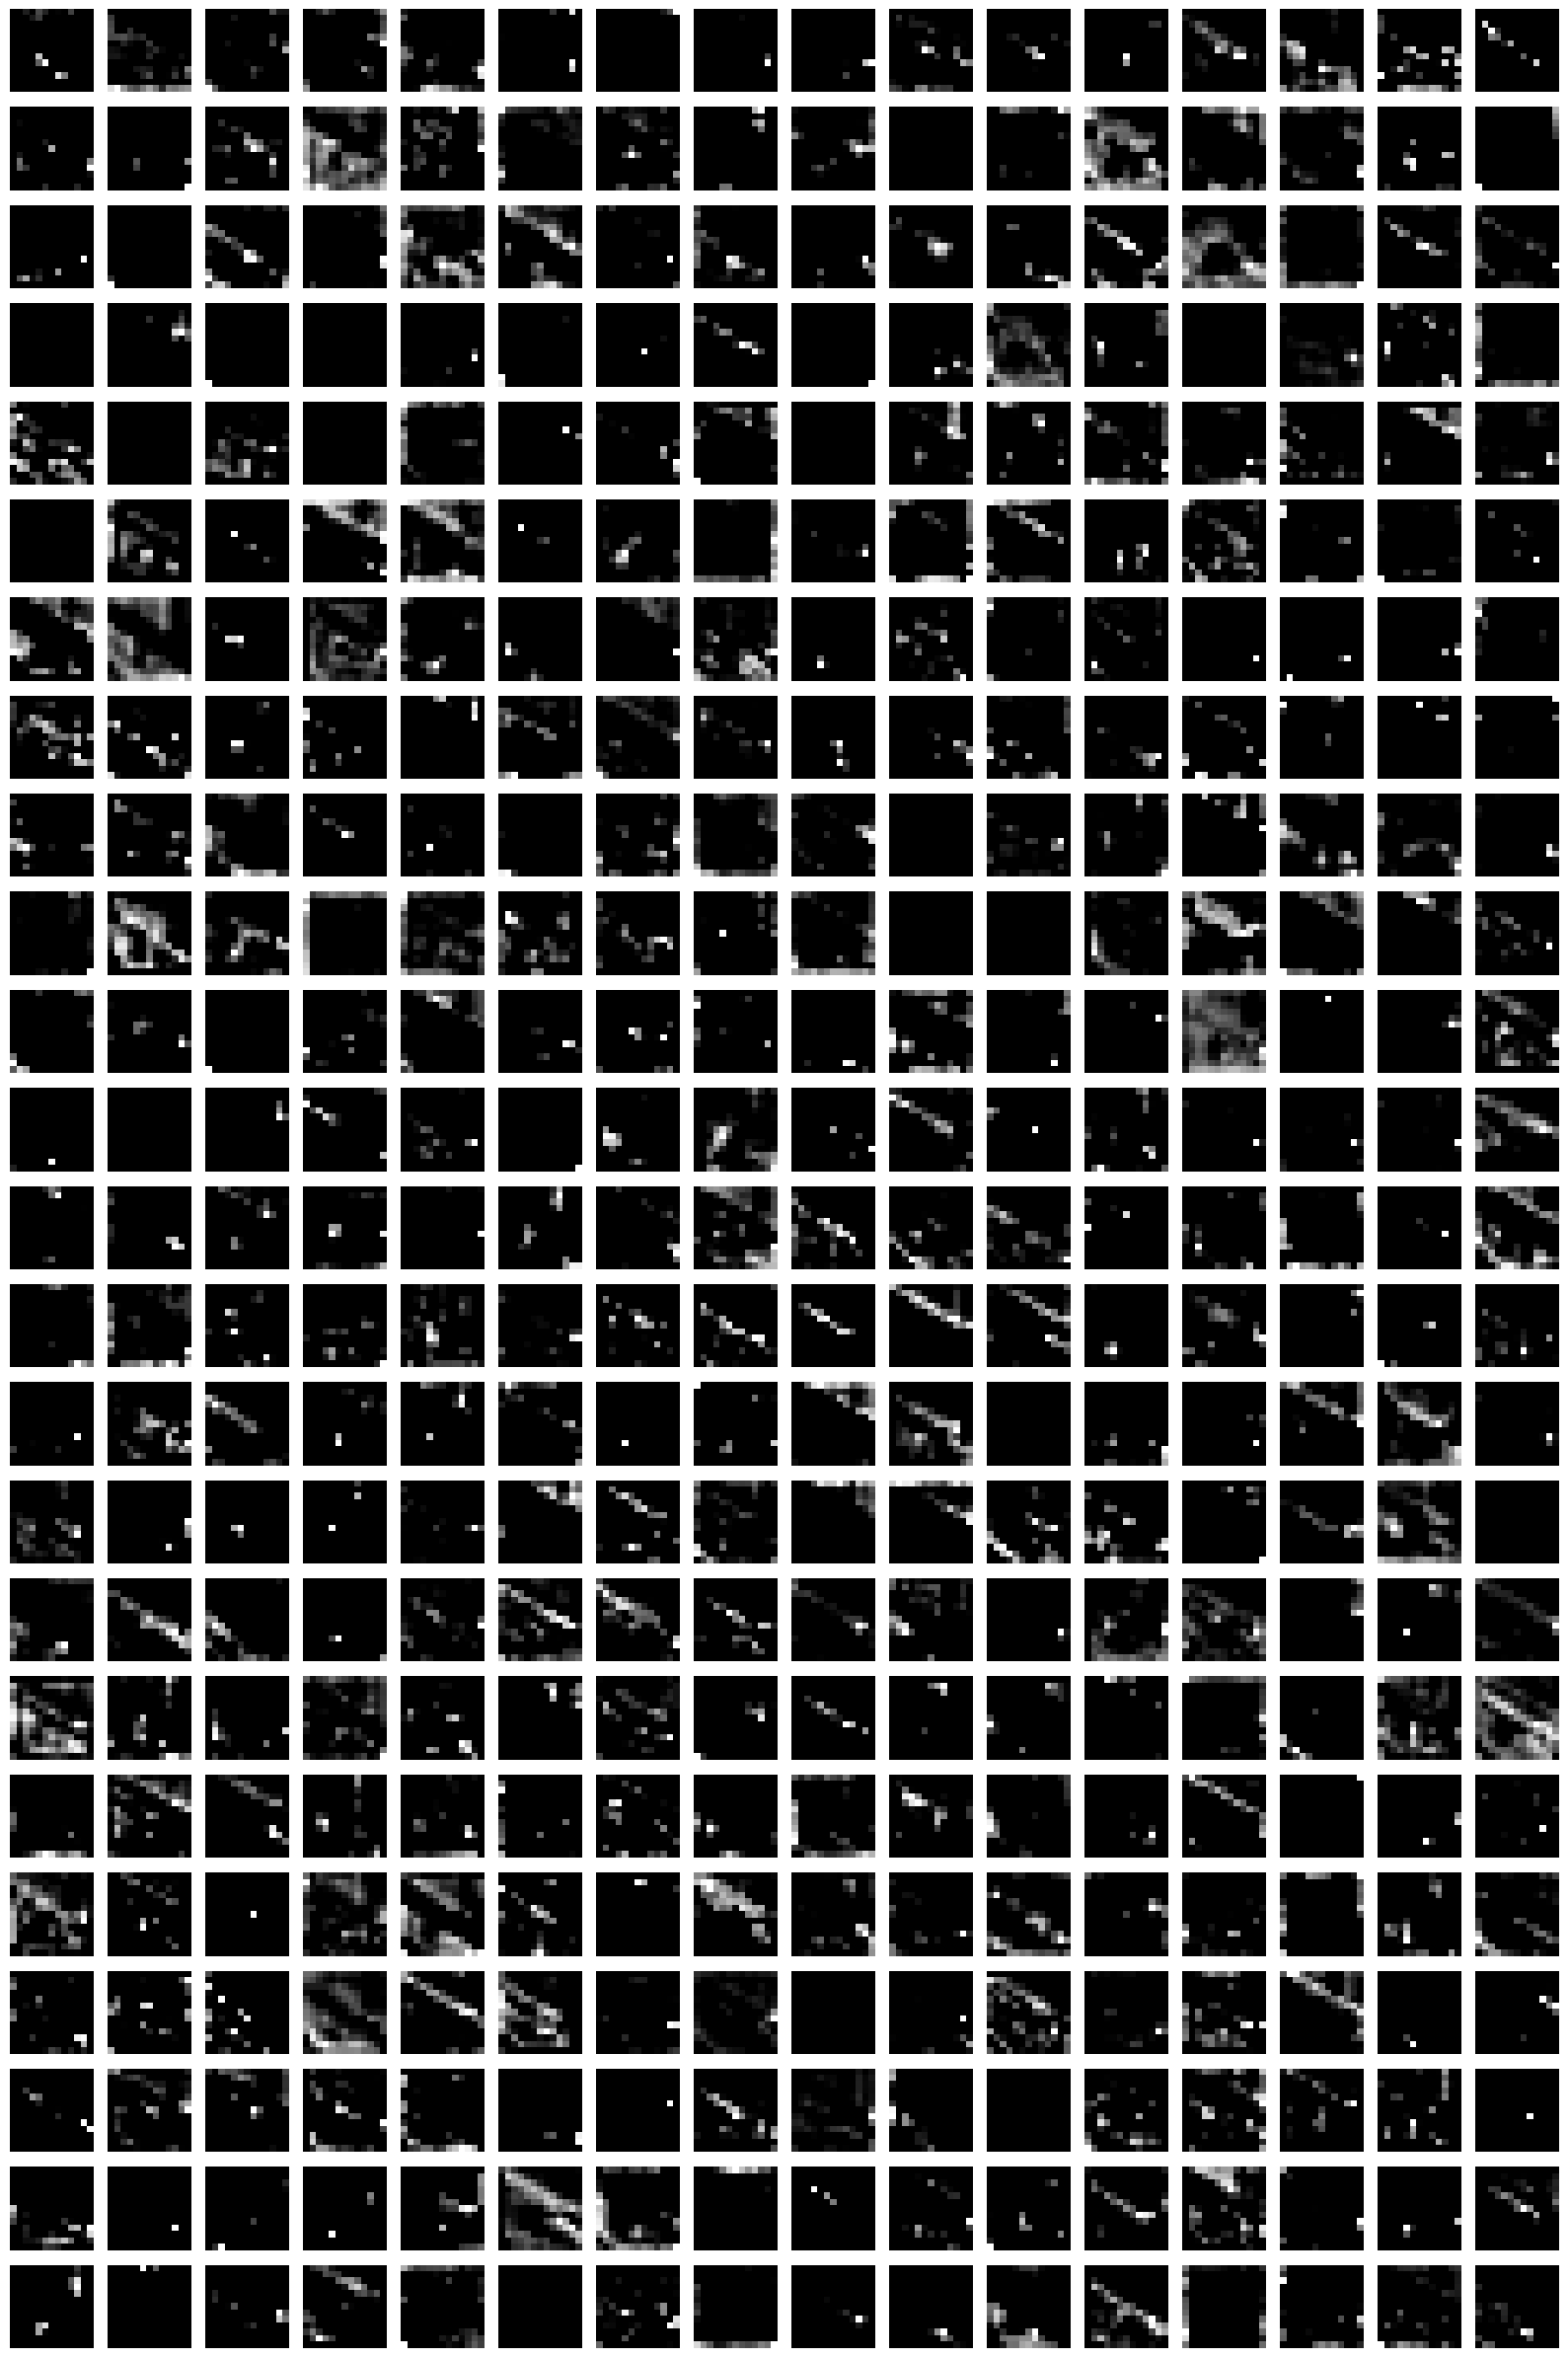

In [100]:
fig, axes = plt.subplots(24, 16, figsize=(16, 24))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(alexnetnp._block3[0][i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Block 4

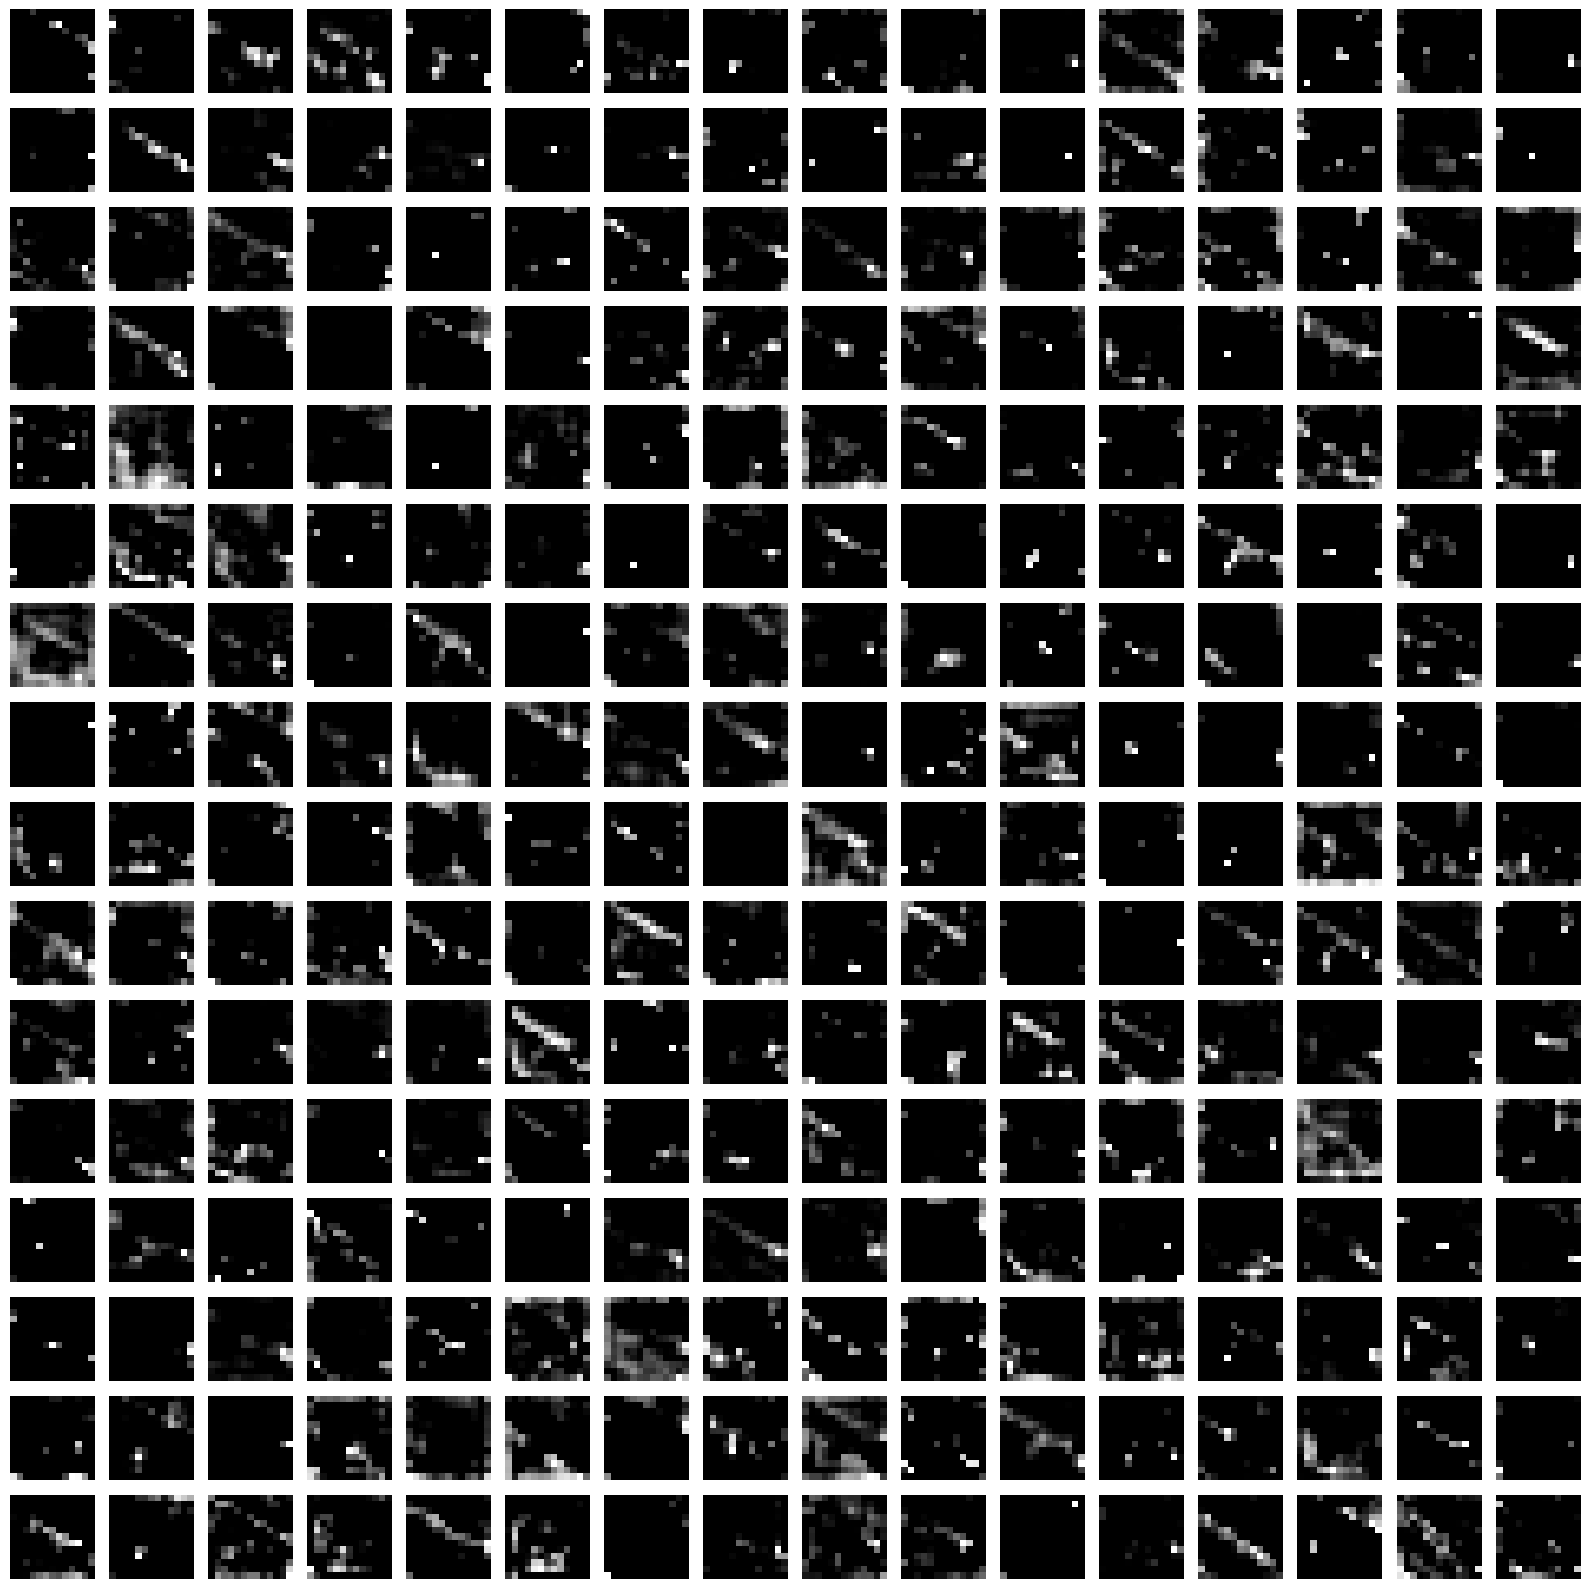

In [104]:
fig, axes = plt.subplots(16, 16, figsize=(16, 16))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(alexnetnp._block4[0][i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Block 5

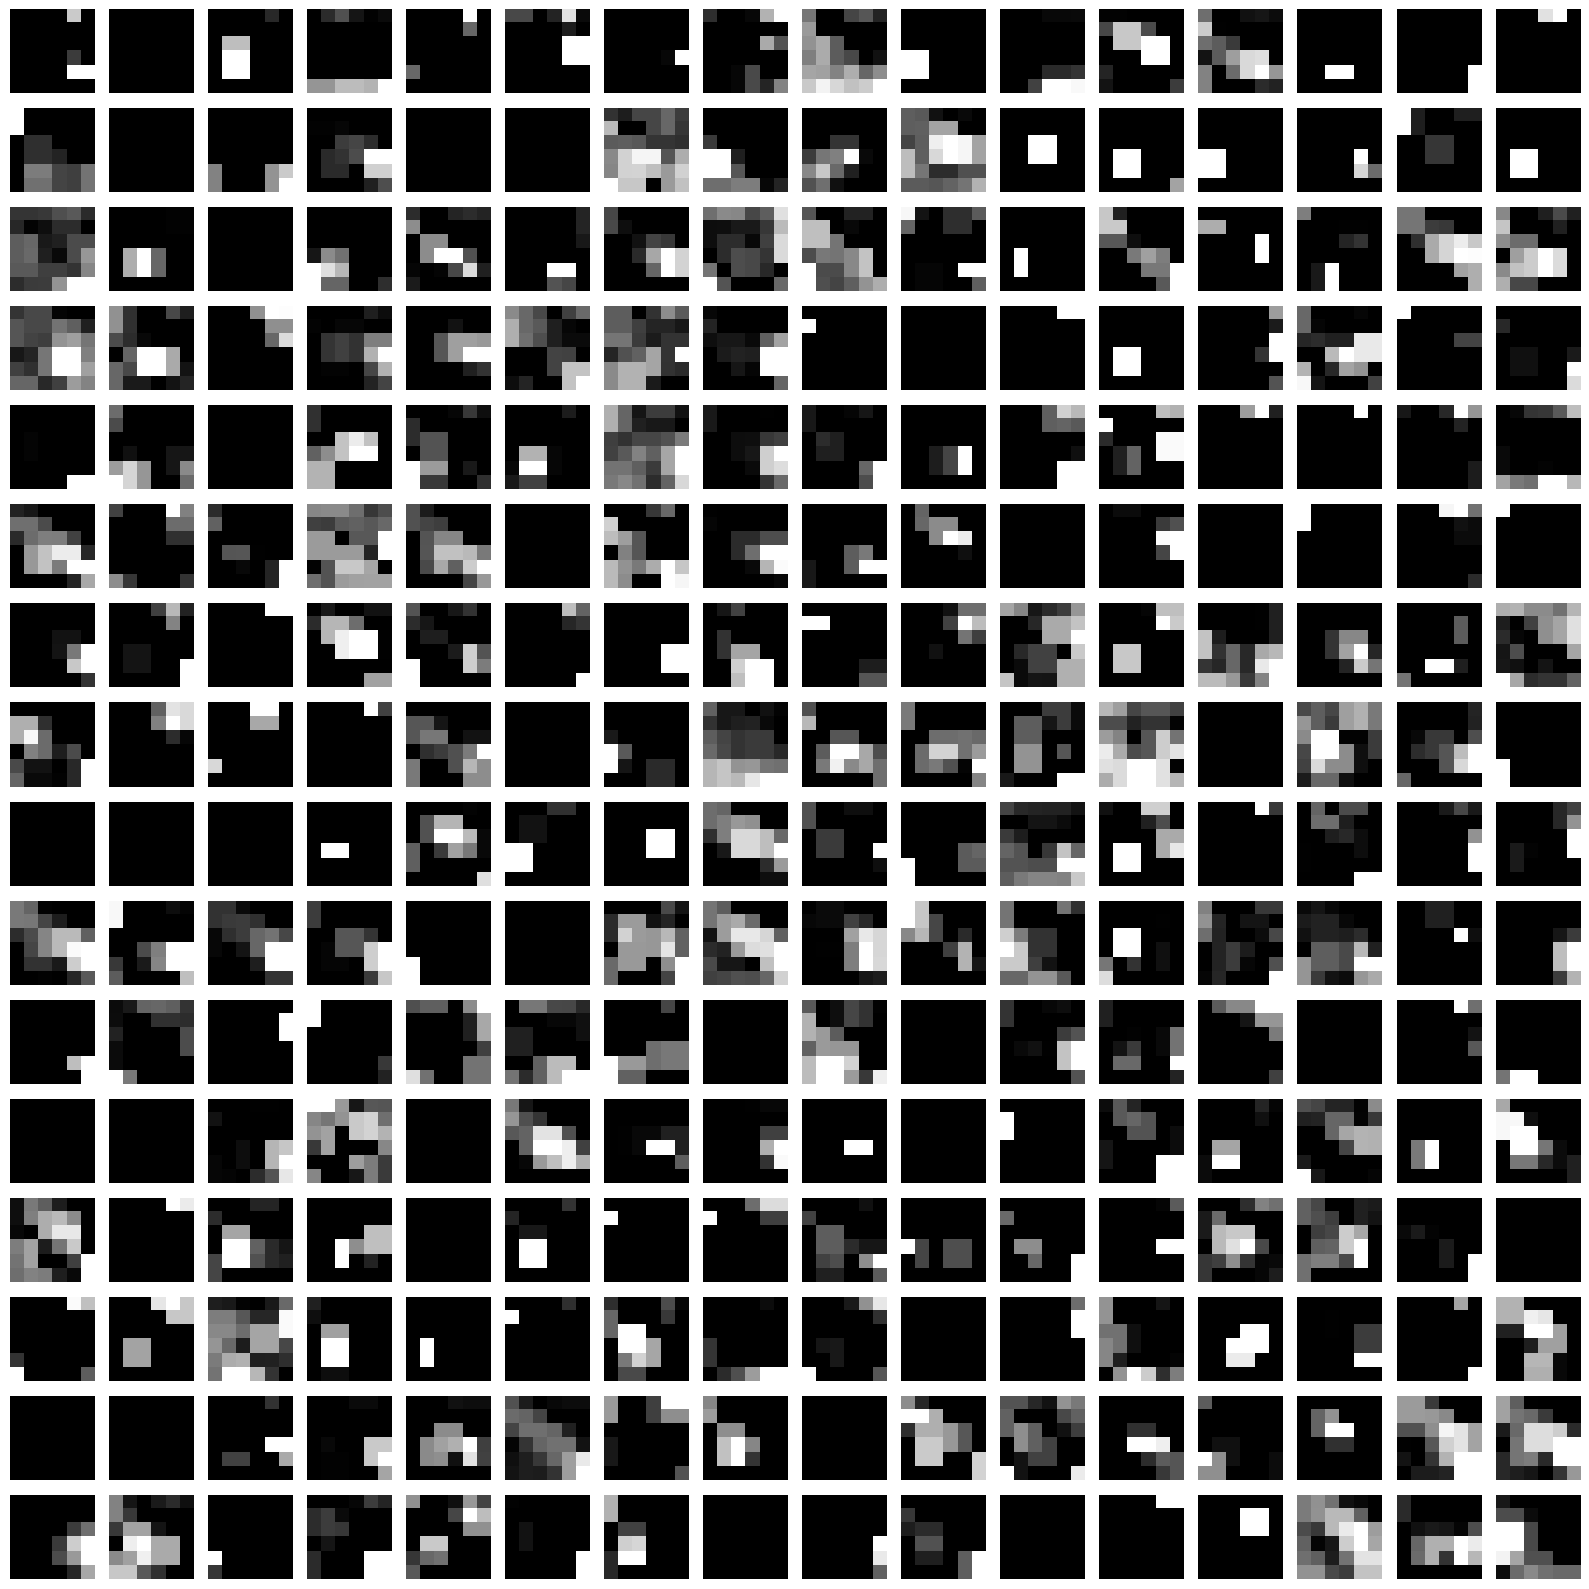

In [106]:
fig, axes = plt.subplots(16, 16, figsize=(16, 16))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(alexnetnp._block5[0][i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Data Source

Russakovsky, O., Deng, J., Su, H., Krause, J., Satheesh, S., Ma, S., Huang, Z., Karpathy, A., Khosla, A., Bernstein, M., Berg, A. C., & Fei-Fei, L. (2014). *ImageNet Large Scale Visual Recognition Challenge*. arXiv:1409.0575. https://arxiv.org/abs/1409.0575
